# clustering of reviews of fine foods bought on amazon #

**importing and cleaning the dataset**

In [ ]:
import pandas as pd

In [1232]:
import CLUSTER_MOD as mod

In [1117]:
df1=pd.read_csv("/Users/eugeniobaldo/Downloads/archive-2/Reviews.csv", nrows=50000,header="infer")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Id                        50000 non-null int64
ProductId                 50000 non-null object
UserId                    50000 non-null object
ProfileName               49997 non-null object
HelpfulnessNumerator      50000 non-null int64
HelpfulnessDenominator    50000 non-null int64
Score                     50000 non-null int64
Time                      50000 non-null int64
Summary                   49998 non-null object
Text                      50000 non-null object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB


In [1118]:
df1.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [1119]:
df1["ProfileName"].fillna("",inplace=True)
df1["Summary"].fillna('',inplace=True)



In [1120]:
df1.set_index("Id", inplace=True)




In [1121]:
df1['Datetime']=df1.Time.apply(lambda value: pd.to_datetime(value, unit='s'))

In [1123]:
df1

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime
Id,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21
...,...,...,...,...,...,...,...,...,...,...
49996,B00430B73W,AKW867T7C6HF8,HWJ3,0,0,5,1261180800,Grown to really like them,My sister introduced me to these. They have be...,2009-12-19
49997,B00430B73W,A2PEHNEDMHOYTW,L. Allen,0,0,5,1258934400,Healthy Snack at a great price!,A friend recommended these bars and I fell in ...,2009-11-23
49998,B00430B73W,A2QH2KF2IAB143,"J. A. Meyers ""Jan""",0,0,5,1257379200,Raw Revolution Hazelnut Cashew,Fabulous! I take one to work with me every da...,2009-11-05


**in this section it will be used NLTK in order to process the review plain text, and then it will be added a column with the tokens to the dataset**

In [1124]:
stop_words=set(stopwords.words('english'))

In [1125]:
wordlist_1=df1["Text"].apply(lambda text: mod.new_text(text,stop_words))

In [1126]:
wordlist_1

Id
1        [bought, several, vitality, canned, dog, food,...
2        [product, arrived, labeled, jumbo, salted, pea...
3        [confection, around, century, light, pillowy, ...
4        [looking, secret, ingredient, robitussin, beli...
5        [great, taffy, great, price, wide, assortment,...
                               ...                        
49996    [sister, introduced, become, favorite, carry, ...
49997    [friend, recommended, bar, fell, love, great, ...
49998    [fabulous, take, one, work, every, day, feel, ...
49999    [love, bar, continue, buy, beware, occasionall...
50000    [good, nutritious, great, flavor, texture, min...
Name: Text, Length: 50000, dtype: object

In [1127]:
df1["taken_words"]=wordlist_1

In [1128]:
df1.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,taken_words
Id,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,..."
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea..."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, century, light, pillowy, ..."
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli..."
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,"[great, taffy, great, price, wide, assortment,..."


**the idea of our group is to cluster the reviews text by taking into account only the adjectives. This choice is related to the role played by adjectives in the sentence. the use of a particular combinations of adjectives rather than other one gives a specific connotation to the text. It has been decided to use as dimensions only the first 1000 most popular adjectives in the reviews. This allows to consider general adjectives and not adjectives that are too specific.** 

In [1129]:
adj_list=df1["taken_words"].apply(lambda wordlist_1: mod.take_adj(wordlist_1))
df1["adjectives"]=adj_list
list_agg=adj_list.to_list()

In [1131]:
flat_list_adj= [item for sublist in adj_list for item in sublist]

In [1132]:
flat_list_adj

['several',
 'dog',
 'good',
 'finicky',
 'labeled',
 'peanut',
 'small',
 'unsalted',
 'sure',
 'represent',
 'nut',
 'filbert',
 'tiny',
 'powdered',
 'tiny',
 'mouthful',
 'flavorful',
 'yummy',
 'familiar',
 'lewis',
 'secret',
 'good',
 'great',
 'taffy',
 'great',
 'wide',
 'quick',
 'wild',
 'enjoyable',
 'many',
 'much',
 'particular',
 'favorite',
 'delightful',
 'great',
 'soft',
 'candy',
 'expensive',
 'good',
 'soft',
 'healthy',
 'good',
 'good',
 'small',
 'puppy',
 'unique',
 'ingredient',
 'hot',
 'bottle',
 'anywhere',
 'magic',
 'ecstatic',
 'hot',
 'hot',
 'personal',
 'incredible',
 'lose',
 'felidae',
 'new',
 'different',
 'new',
 'full',
 'touch',
 'similar',
 'related',
 'new',
 'good',
 'fresh',
 'delicious',
 'guilty',
 'hit',
 'good',
 'fresh',
 'satisfied',
 'pennsylvania',
 'young',
 'green',
 'licorice',
 'dry',
 'cool',
 'guinness',
 'measured',
 'guinness',
 'reasonable',
 'unable',
 'many',
 'amazon',
 'fresh',
 'arrive',
 'timely',
 'bought',
 'overse

In [1133]:
adjectives_list=pd.Series(flat_list_adj).value_counts()

In [1134]:
all_adjectives=list(adjectives_list[0:1000].index)

len(all_adjectives)

1000

**here it is created a dictionary where reviews are the keys and vectors of size 1000 are the values. In order to represent a particular review text has been decided to use a binary representation for each adjective considered. If the adjective is in the review text, it will be assigned 1, otherwise it will be assigned 0.**

In [1135]:
dict_adj=mod.df_words_dict(list_agg,all_adjectives)

**here it is created a dataset where each row is a review as in the starting one, whereas the columns are the adjectives.**

In [1140]:
df_adjectives=pd.DataFrame.from_dict(data=dict_adj, orient='index',columns=all_adjectives)

In [1141]:
df_adjectives.columns

Index(['good', 'great', 'br', 'little', 'much', 'many', 'hot', 'sweet',
       'delicious', 'favorite',
       ...
       'bed', 'gary', 'hershey', 'native', 'routine', 'oral', 'unexpected',
       'oreo', 'creative', 'tip'],
      dtype='object', length=1000)

**SVD method to reduce the dimensionality** 

**the SVD method is used to reduce the number of features which will be used for clustering and in general for machine learning models. This method allows to save computation time but at the same time to save a good amount of information provided by the features. It has been set a target value for the variance retained of 60%. So it will be choosen a number of components which is capable of retaining 60% of all the variance.**

In [1142]:
from sklearn.decomposition import TruncatedSVD as SVD

In [1147]:
svd_agg= SVD(n_components=115, n_iter=7, random_state=42)

df_adj=svd_agg.fit_transform(df_adjectives, y=None)

print(svd_agg.explained_variance_ratio_.sum())

0.6002357801109249


**having the number of components to be used, they will be taken the top features ordered in descending order by variance. These features will approximately correspond to the most popular adjectives.**

In [1148]:
columns_variance=mod.variance_columns(df_adjectives,115)

In [1149]:
df_adjectives=df_adjectives[columns_variance]

df_adjectives

,good,great,little,much,br,delicious,many,favorite,nice,sweet,...,bold,normal,daily,want,picky,bean,weak,entire,add,particular
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**elbow method for number of cluster selection**

**the number of clusters can be utmost the total number of rows. Given certain  boundaries, the more are the cluster the more specific will be the clustering. However an high number of clusters can raise computational problems. To choose an acceptable number of clusters, it will be used the elbow method which computes the inertia for a specific cluster number. From the following plot, it is possible to observe the inertia curve for clusters numbers in range(2,30). the first derivative of this curve appears less negative after a cluster number of 14. So, it will be used 14 as cluster number.**

In [1150]:

elbow = {}
for k in tqdm(range(2, 30)):
    model = KMeans(k)
    model.fit(df_adjectives)
    model.predict(df_adjectives)    
    elbow[k] = model.inertia_

100%|██████████| 28/28 [07:09<00:00, 15.34s/it]


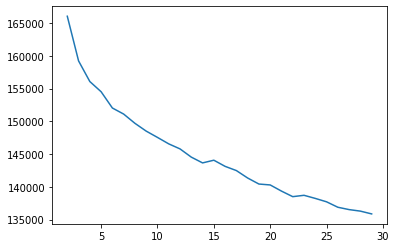

In [1151]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('cluster number')
plt.ylabel('inertia')
plt.plot(list(elbow.keys()), list(elbow.values()), color='red', linestyle='dotted')
plt.show()

**nested list to be used for our own clustering implementation**

In [1152]:
word_vector1=[]

for idx in range(len(df_adjectives)):
    
    list_w1=list(df_adjectives.iloc[idx])
    
    word_vector1.append(list_w1)
    


**in the following section will be executed two k-means algorithm. The first is our own algorithm with random initialization, the second is the one provided from sk-learn with k++ initialization.**

**our k-means implementation**

In [1159]:
my_clusters=mod.cluster_labels(word_vector1,10,14)

print(my_clusters[0:1000])

[0, 8, 8, 0, 2, 13, 2, 0, 8, 0, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8, 6, 8, 8, 8, 8, 1, 8, 7, 10, 8, 4, 2, 9, 9, 0, 2, 8, 4, 0, 8, 9, 3, 2, 0, 0, 13, 0, 0, 8, 8, 0, 10, 8, 13, 2, 13, 13, 2, 2, 6, 0, 0, 8, 2, 8, 8, 5, 11, 0, 11, 4, 3, 9, 11, 8, 8, 0, 0, 2, 0, 4, 13, 3, 12, 12, 10, 8, 10, 12, 9, 12, 2, 9, 4, 8, 10, 10, 8, 8, 8, 8, 8, 2, 8, 8, 2, 8, 8, 2, 5, 5, 8, 3, 2, 7, 8, 2, 9, 3, 9, 6, 13, 6, 0, 8, 13, 13, 11, 4, 8, 8, 0, 8, 2, 8, 11, 8, 8, 8, 8, 8, 0, 1, 2, 6, 4, 4, 8, 8, 2, 8, 8, 0, 0, 0, 2, 8, 8, 1, 8, 2, 13, 5, 4, 8, 4, 8, 6, 0, 2, 8, 8, 8, 8, 11, 8, 8, 0, 0, 8, 5, 2, 12, 1, 9, 8, 2, 11, 3, 8, 9, 2, 7, 9, 8, 10, 1, 6, 2, 13, 1, 4, 2, 0, 2, 8, 8, 7, 10, 1, 13, 13, 12, 8, 8, 2, 8, 0, 2, 8, 8, 0, 8, 2, 8, 4, 13, 4, 8, 7, 8, 12, 8, 8, 0, 1, 9, 3, 13, 2, 1, 0, 8, 8, 2, 3, 13, 2, 4, 10, 2, 8, 8, 6, 8, 3, 8, 0, 1, 0, 9, 2, 7, 13, 8, 2, 8, 13, 8, 2, 0, 0, 2, 13, 0, 11, 2, 10, 0, 0, 8, 8, 0, 0, 8, 0, 0, 13, 1, 0, 12, 2, 11, 12, 8, 1, 8, 12, 2, 6, 0, 0, 0, 8, 8, 8, 13, 8, 9, 0, 9, 8, 8, 13, 6, 11,

**sklearn with k++ initialization results**

In [1249]:
kmeans = KMeans(n_clusters=14,init='k-means++', max_iter=10, verbose=False).fit(df_adjectives)

clusters=kmeans.labels_

print(clusters[0:1000])

[ 1  0  0  1  4 13  4  1  0  1  0  0  0  3  0  0  1  0  0  0  0  0  0  0
  8  2  0 12  4  0  6  4  4  4  1  4  8 10  1  0  7  6  4  1  1 10  1  1
  0  0  1  0  0 13  4  3 13  5  5  0  1  1  0  4  0  0  2  0  1  0  6  6
  4  6  0  0  5  1  4  1  3  4  7  9  9  4  0  0  9  5  9  4  4 10  0  9
  9  0  0  0  0  0  5  0  0  4  0  0  4  1  0  0  7  4 12  0  4  8  6  4
  0 13  0  1  0 13  4  0  6  0  0  1  0  4  0  0  0  3  0  0  0  1  2  4
  0 10  3  0  0  4  0  0  1  1  1  4  0  5  3  0  4 13  4 10  0 10  0  0
  1  4  5  8  3  5  1  0  0  1  1  0  4  9 11  2  4  0  4  0 13  0  4  4
 12  6  0 10  2  0  4 13  2 10  4  1  4  3  0  3 10  2 13  8  9  0 11  4
  0  8 10  0  0  1  3  4  0 10 10 10  0 12  0  9  0  0  1  2  4  7  2 10
  1  1  0  0  4 13  4  4  6  0  4  0  0  0  0  7  0  1  2  1  4  4 12 13
  0  4  0  8  0  3  1  1  4 13  1  9  4  3  1 11  0  0  1 13  0  1  1 13
  1  1  9  4  9  6  0  2  0  9  4  3  1  1  1  0  0 11 11  0  4  1  4  0
  0 11  0  1 10 13  2  0  3  0  0  0  0  0 13  0  1

**cluster values for both algorithms are added to the starting dataset**

In [1250]:
df1["own_cluster"]=my_clusters
df1["sklearn_cluster_k++"]=clusters
df1.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,taken_words,adjectives,own_cluster,sklearn_cluster_k++
Id,,,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,...","[several, dog, good, finicky]",0,1
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea...","[labeled, peanut, small, unsalted, sure, repre...",8,0
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, century, light, pillowy, ...","[nut, filbert, tiny, powdered, tiny, mouthful,...",8,0
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli...","[secret, good]",0,1
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,"[great, taffy, great, price, wide, assortment,...","[great, taffy, great, wide, quick]",2,4


**comments about results differences between our clustering implementation and sklearn implementation using histograms**

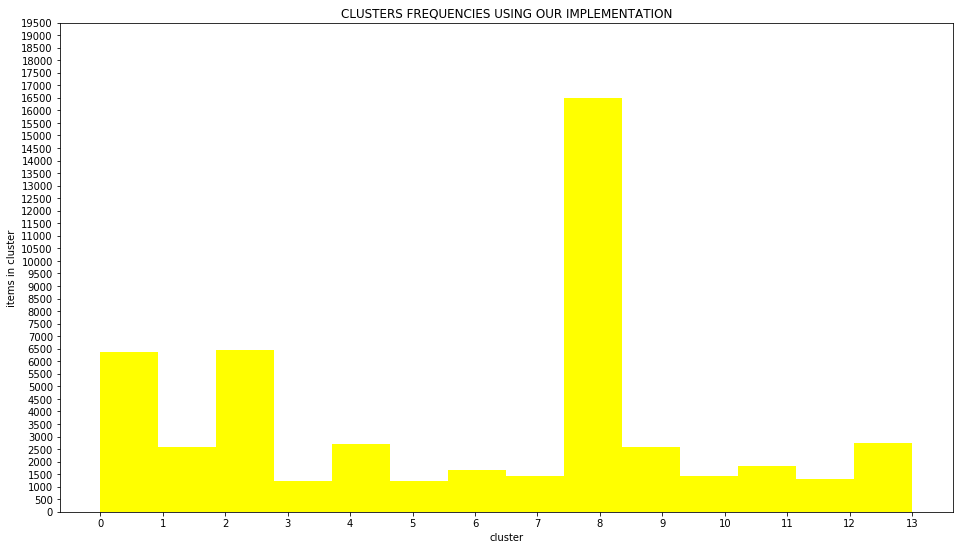

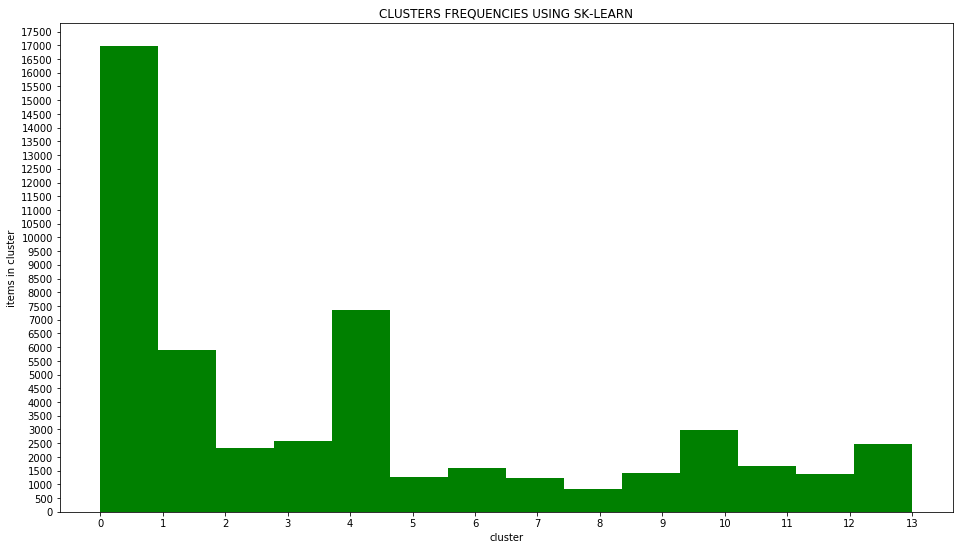

In [1251]:
plt.figure(figsize=(16,9))

plt.title("clusters frequencies using our implementation".upper())

plt.hist(my_clusters,color='yellow',bins=14)

plt.xticks(np.arange(0,14,1))

plt.yticks(np.arange(0,20000,500))

plt.xlabel("cluster")

plt.ylabel('items in cluster')

plt.show()



plt.figure(figsize=(16,9))

plt.title('clusters frequencies using sk-learn'.upper())

plt.xticks(np.arange(0,14,1))

plt.yticks(np.arange(0,20000,500))

plt.hist(clusters, color='green',bins=14)

plt.xlabel("cluster")

plt.ylabel('items in cluster')

plt.show()

**In the previous histograms it is possible to observe the number of reviews for each cluster. The cluster labels of our implementation and sk-learn will not correspond each other, given that the initialization of centers changes each time that the script is executed. It can be observed that for both implementations there exists a major cluster that has the higher number of reviews. Then there are two middle clusters which have approximately the same number in our implementation and slightly difference in sk-learn and finally there are minor clusters. The number of items for the two implementations for each cluster results not equal but looks similar. In addition to graphs, it is possible to see, from the sequences of labels patterns, many common sequences between the two results.**  

## cluster analysis ##

**provide the number of products for each cluster**

In [1255]:
df_count=df1.groupby(["own_cluster"]).count()

df_count=df_count.ProductId

df_count

own_cluster
0      6361
1      2591
2      6434
3      1239
4      2699
5      1235
6      1648
7      1428
8     16502
9      2589
10     1432
11     1812
12     1292
13     2738
Name: ProductId, dtype: int64

**pie chart describing the percentages of products per cluster**

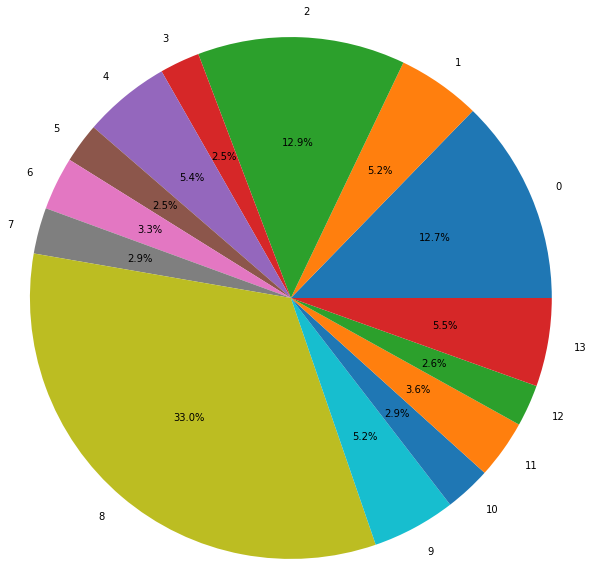

In [1258]:

plt.pie(df_count,labels=df_count.index,radius=3,autopct='%1.1f%%')

plt.show()

**score distribution for each cluster**

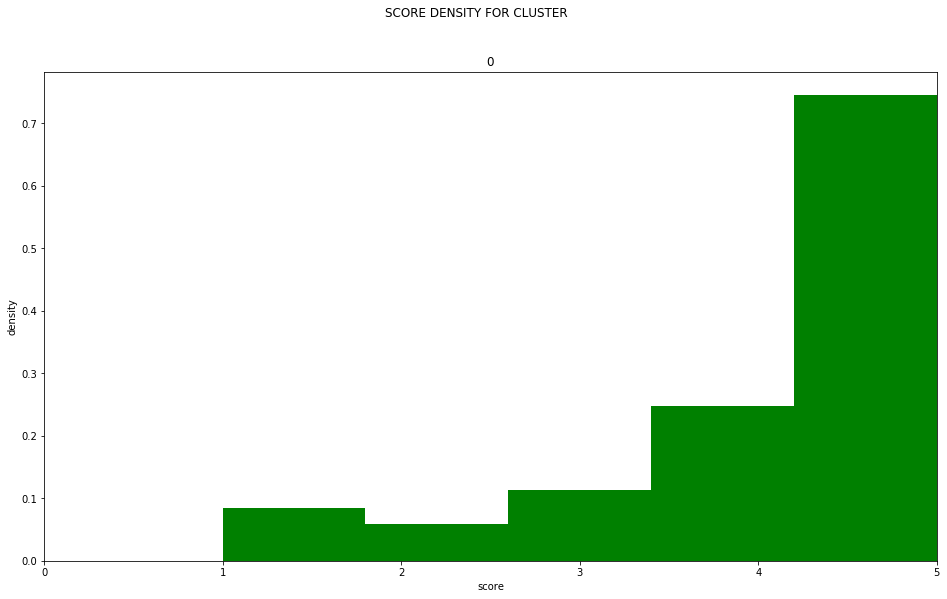

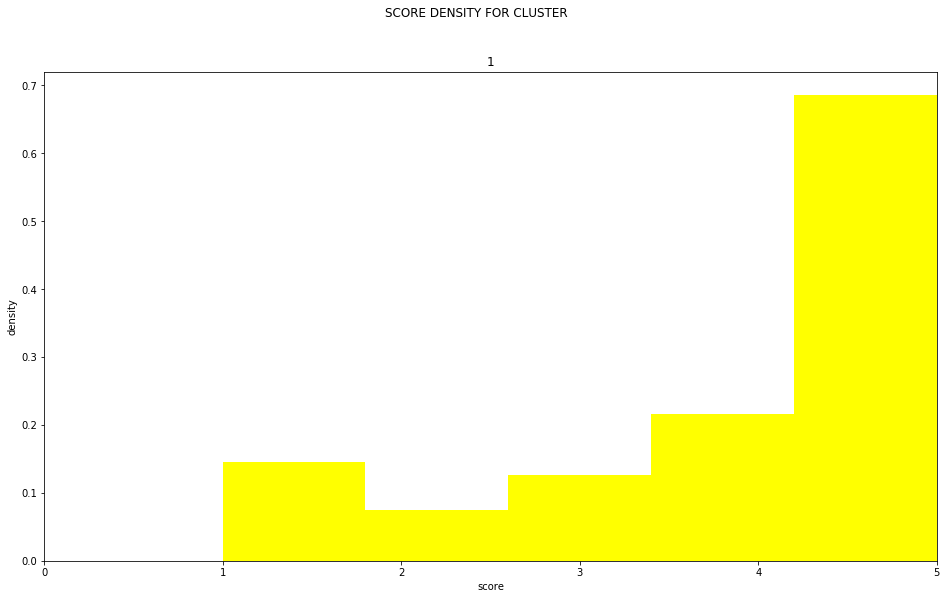

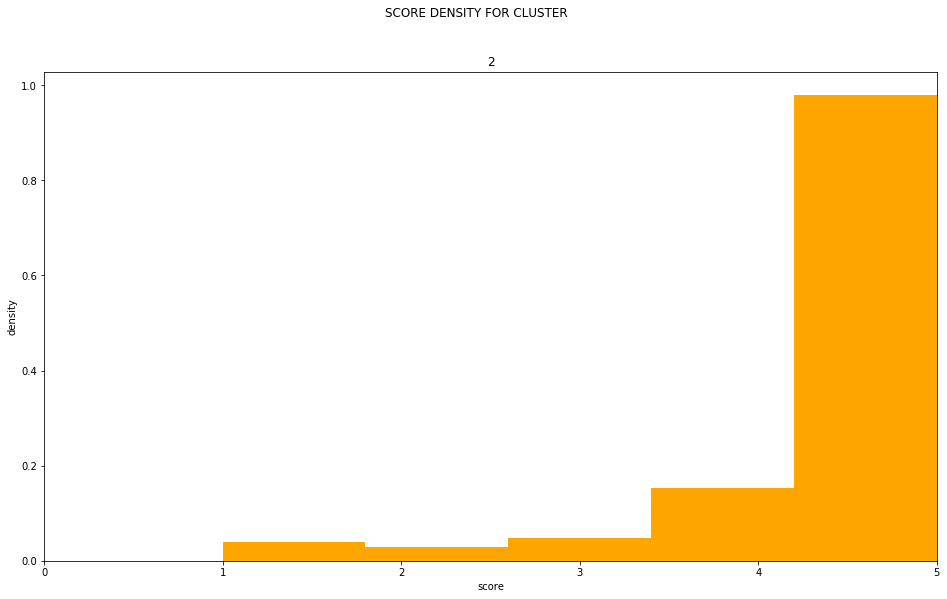

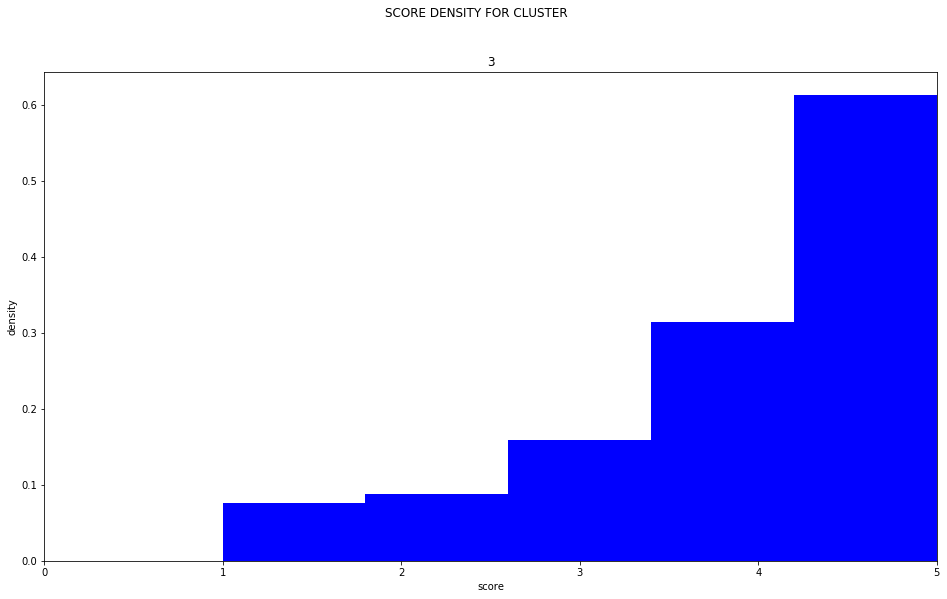

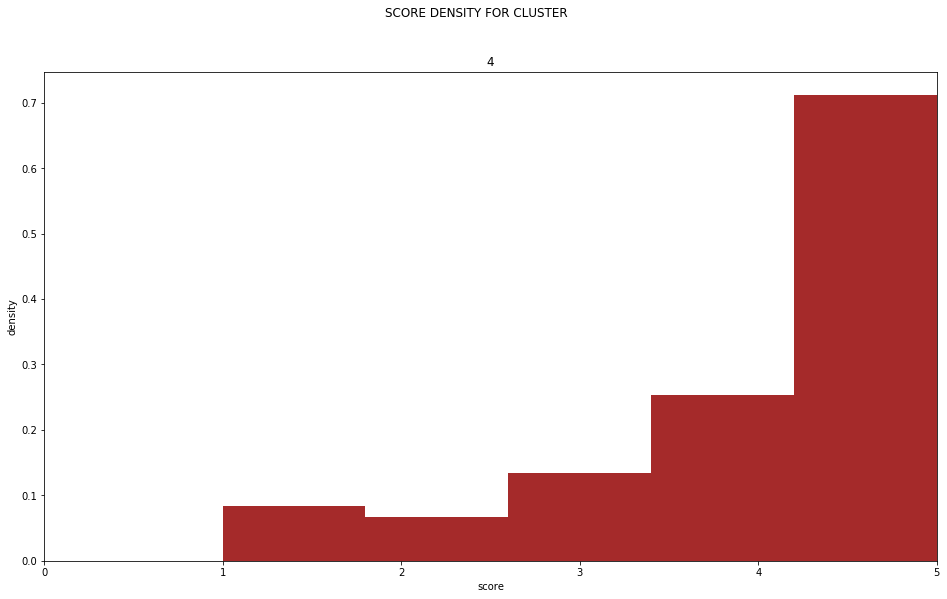

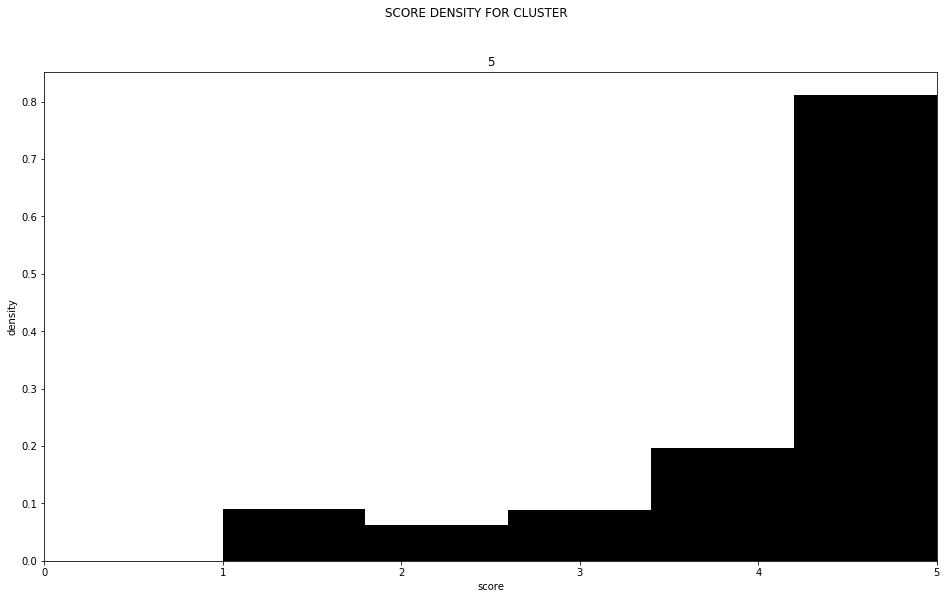

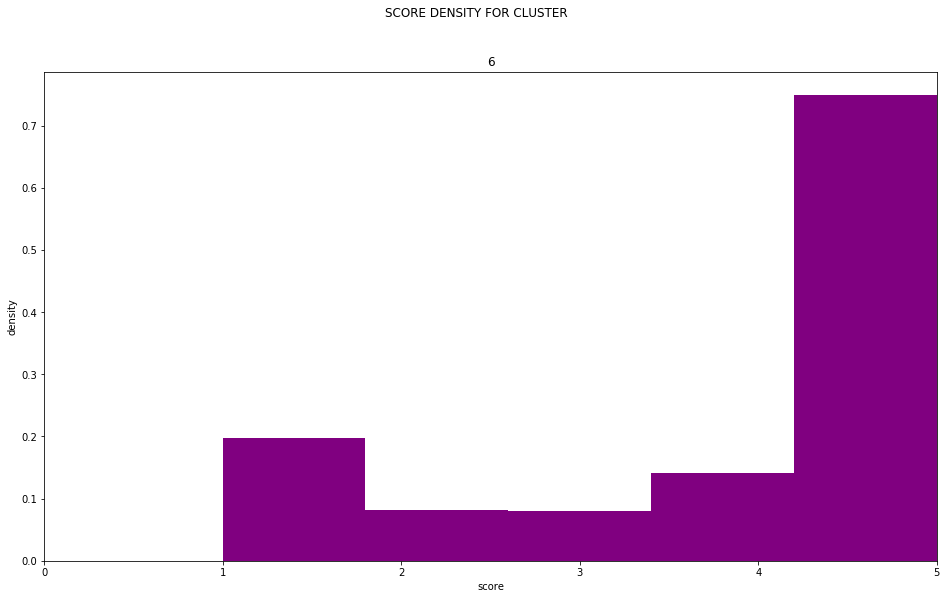

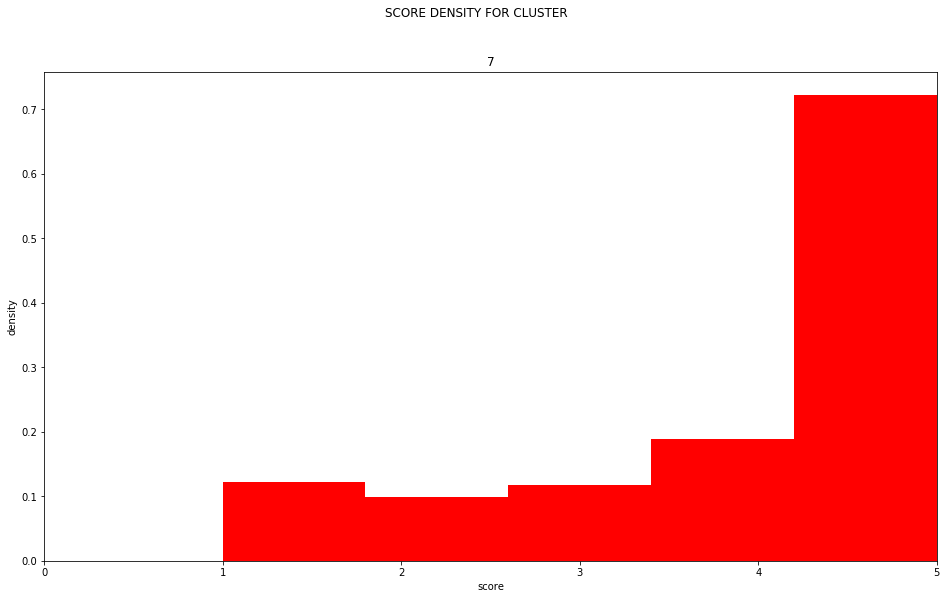

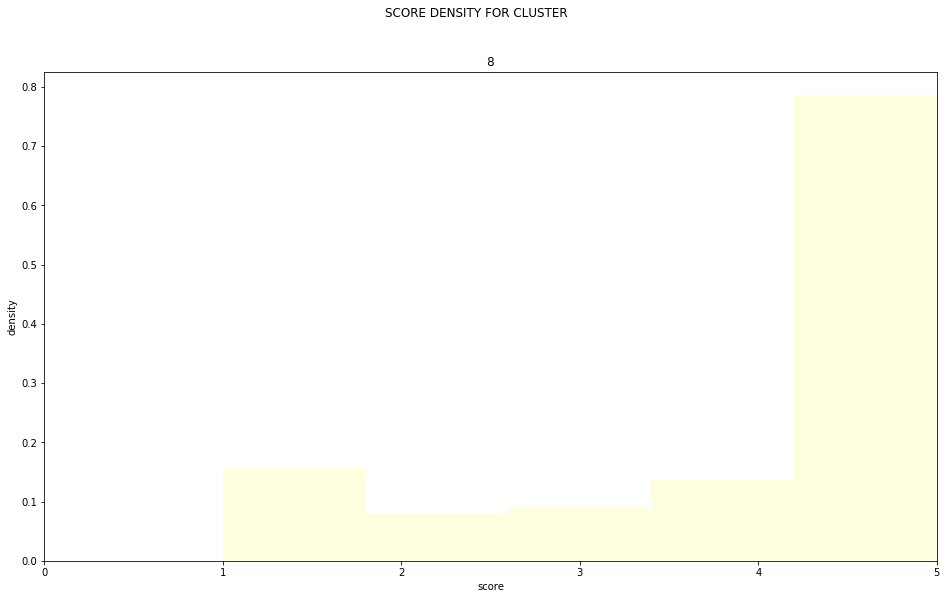

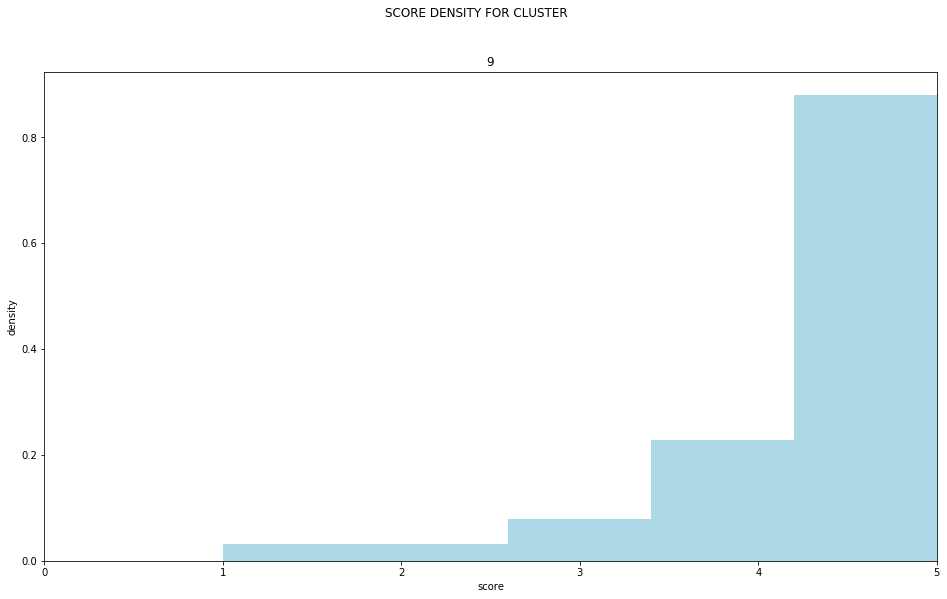

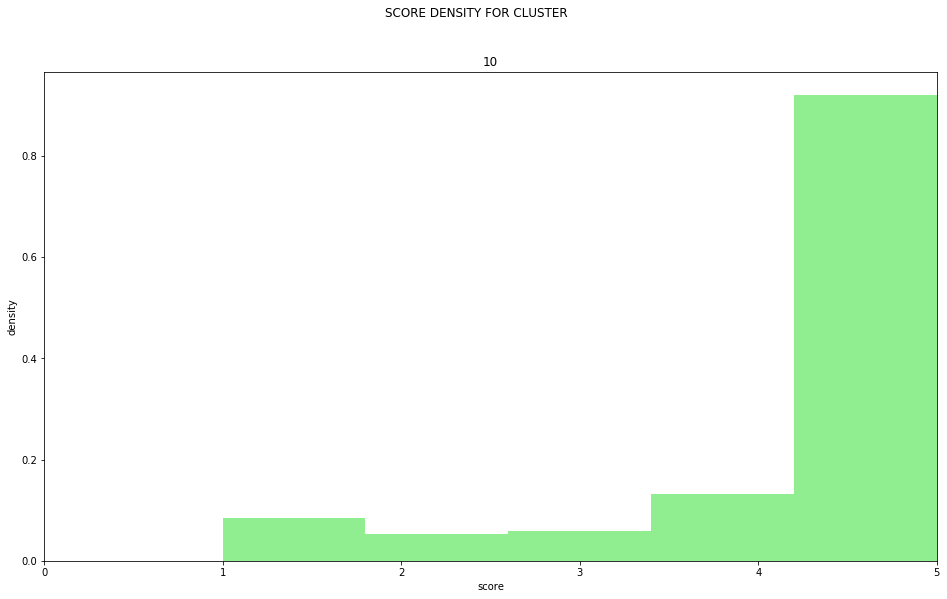

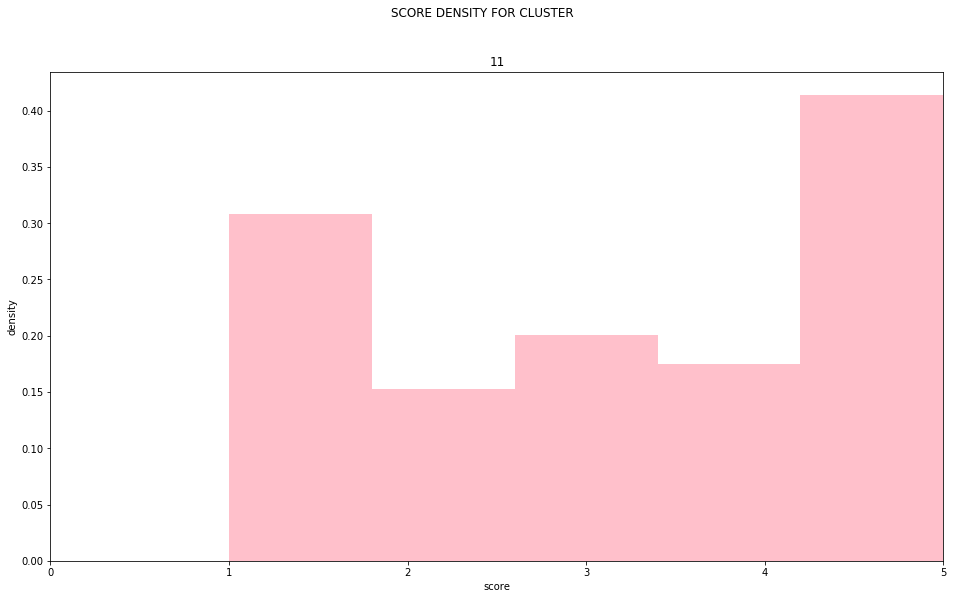

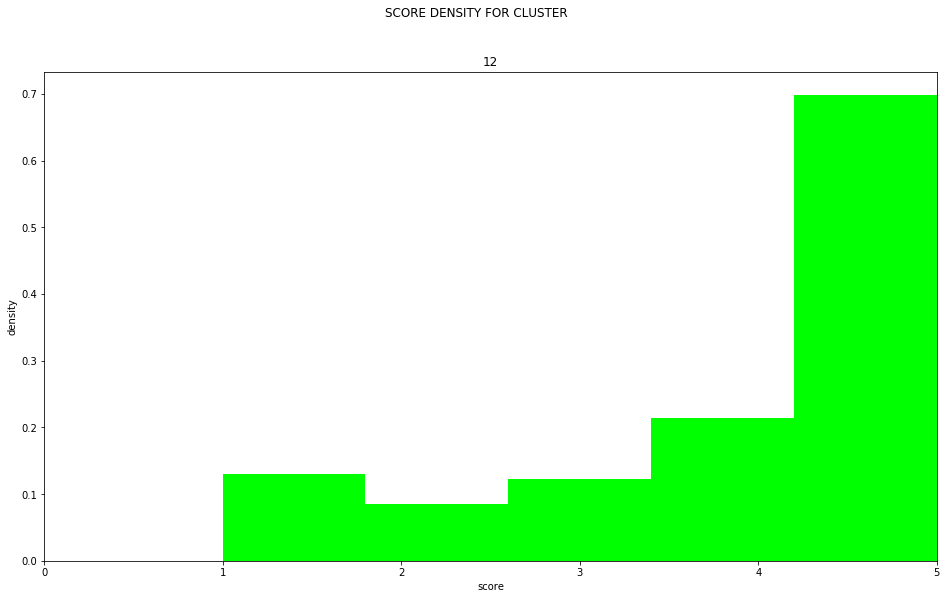

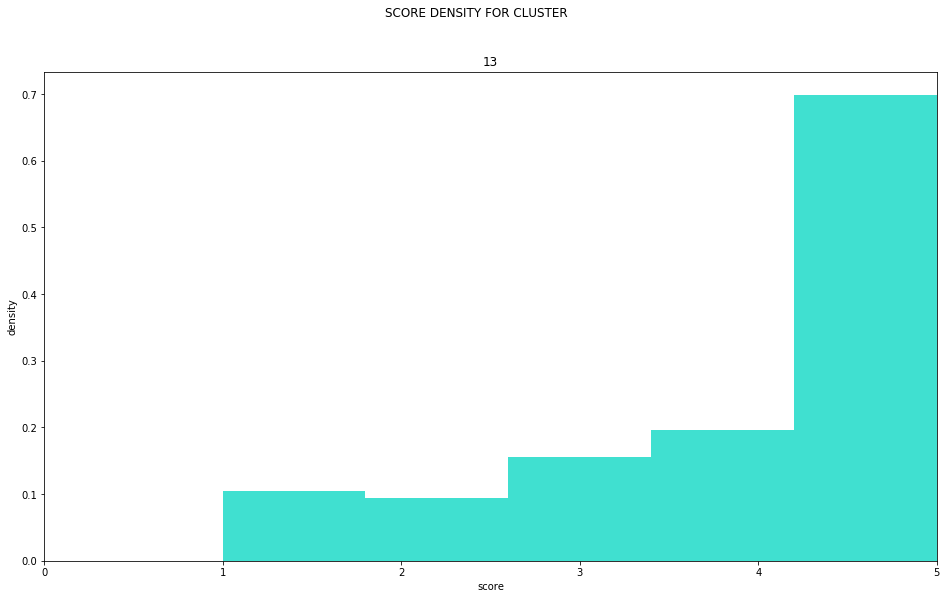

In [1229]:
score=mod.score_distribution(df1,14)

In [1205]:
means=list(score.values())

means

[4.208772205628046,
 3.9760710150521033,
 4.605066832452596,
 4.03954802259887,
 4.15450166728418,
 4.2615384615384615,
 3.9320388349514563,
 4.031512605042017,
 4.052660283601988,
 4.51525685592893,
 4.4001396648044695,
 3.188189845474614,
 4.011609907120743,
 4.033235938641344]

In [1202]:
std=np.std(means)

std

0.3225265324465866

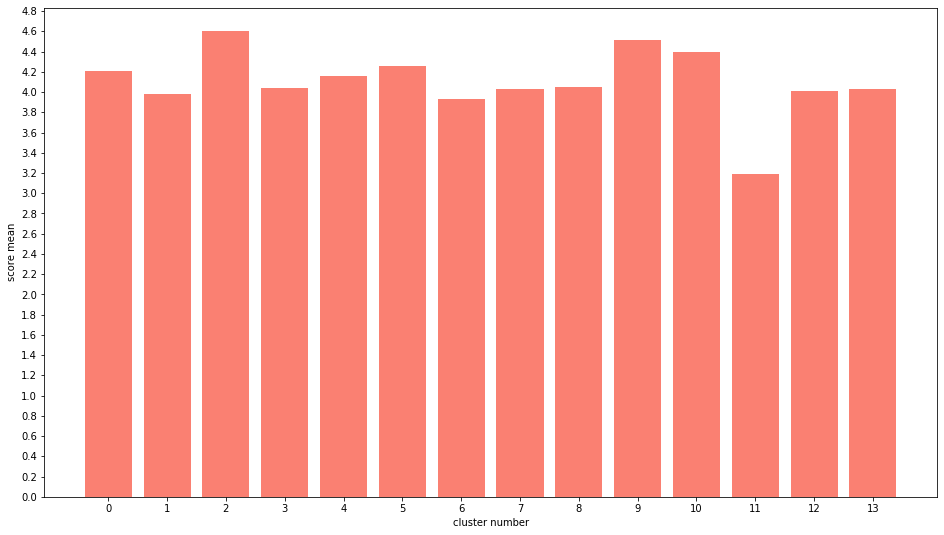

In [1222]:
plt.figure(figsize=(16,9))

plt.bar(list(score.keys()),means,color='salmon')

plt.xlabel("cluster number")

plt.xticks(np.arange(0,14,1))

plt.yticks(np.arange(0,5,0.2))

plt.ylabel('score mean')

plt.show()

**Get the number of unique users writing reviews in each cluster**

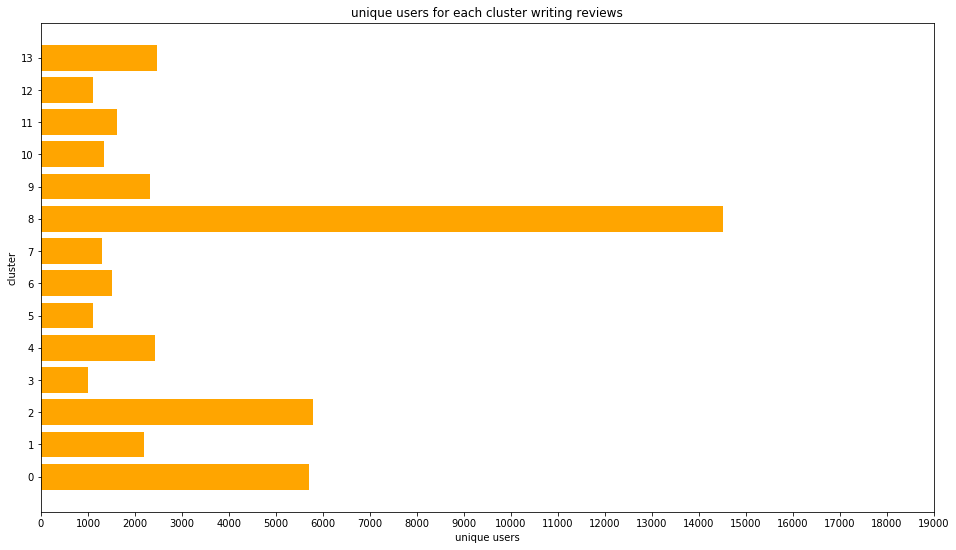

In [1248]:
uniques=mod.unique_users(df1, 14)

plt.figure(figsize=(16,9))
plt.title('unique users for each cluster writing reviews')
plt.barh(uniques.index, uniques, color='orange')
plt.yticks(np.arange(0,14,1))
plt.xticks(np.arange(0,20000,1000))
plt.xlabel('unique users')
plt.ylabel('cluster')
plt.show()

**WordCloud**

In [1097]:
from wordcloud import WordCloud as WC

In [1098]:
from PIL import Image


coffee_image=np.array(Image.open('/Users/eugeniobaldo/Downloads/caffè.jpg'))

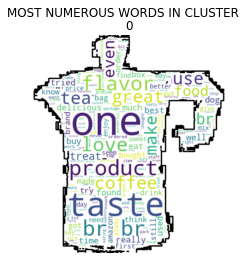

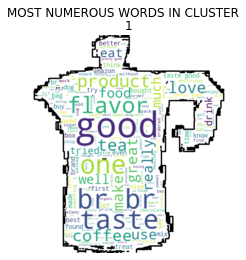

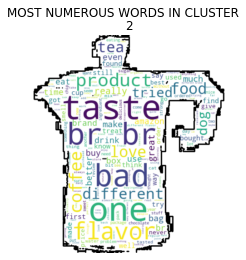

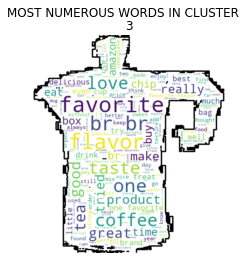

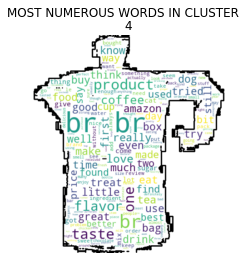

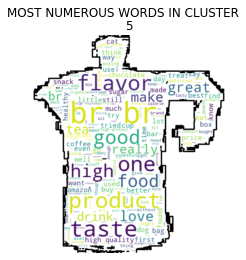

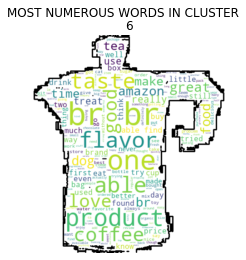

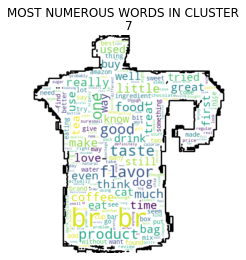

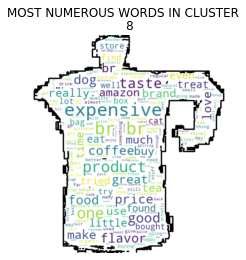

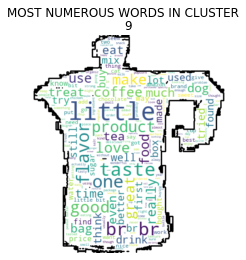

In [1099]:
mod.word_cloud(coffee_image,df1,10)